### Import Libraries

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from torchsummary import summary

### Set device configuration

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load and Preprocess Data

In [ ]:
# Define data transforms

transform = transforms.Compose([
    transforms.ToTensor(),   #converts image/numpy array to pytorch tensor. scales pixel values from [0, 255] (integers) to [0, 1] (floating-point)
    transforms.Normalize((0.5,), (0.5,)) #MNIST is grayscale (single channel), we use (0.5,) instead of three values (RGB). 
                                         # This scales values from [0,1] to [-1,1], making training faster and more stable.
])

In [11]:
# Load Dataset

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [20]:
# create data loaders (batch and shuffle data for training and testing)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# torch.utils.data.DataLoader is a PyTorch utility that helps load and batch data efficiently.
# It iterates over the dataset and automatically batches samples.
# This is useful when working with large datasets that don’t fit into memory.

# 🔹 batch_size=100
# Instead of passing one image at a time, we group images into batches of size 100.
# This speeds up training because batch processing is more efficient than processing one sample at a time.
# 🔹 shuffle=True (for training)
# Shuffles the data in each epoch to introduce randomness.
# Prevents the model from learning order-dependent patterns.
# Improves generalization and avoids overfitting.
# 🔹 shuffle=False (for testing)
# No shuffling because we want to evaluate performance on the same data ordering.
# This ensures consistent and reproducible results.

### Define Neural Network Model

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, padding_mode='zeros')
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = self.relu(x)
        x = self.cn2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

'''
Architecture Breakdown:

The network consists of two convolutional layers, ReLU activations, max-pooling, dropout, and fully connected layers. Let's go step by step:

1️⃣ Input Layer: Takes a 1x28x28 grayscale image (MNIST dataset).

2️⃣ Conv Layer 1: Applies 16 filters of size 3x3, producing a 16x26x26 output.

3️⃣ ReLU Activation: Introduces non-linearity.

4️⃣ Conv Layer 2: Applies 32 filters of size 3x3, producing a 32x24x24 output.

5️⃣ ReLU Activation

6️⃣ Max Pooling (2x2): Reduces the spatial dimensions to 32x12x12.

7️⃣ Dropout (10%): Helps prevent overfitting.

8️⃣ Flatten Layer: Converts 32x12x12 = 4608 into a 1D vector.

9️⃣ Fully Connected Layer 1: Maps 4608 → 64 neurons with ReLU activation.

🔟 Dropout (25%)

1️⃣1️⃣ Fully Connected Layer 2: Maps 64 → 10 neurons (digits 0-9).

1️⃣2️⃣ Log Softmax: Converts output logits into probability scores.

'''

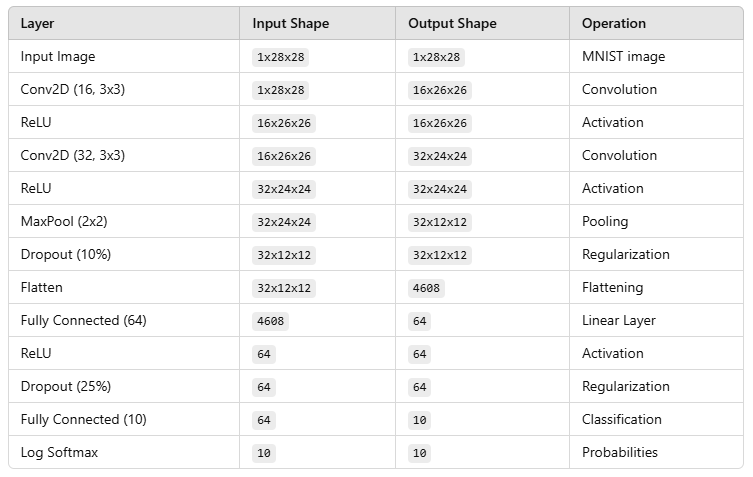

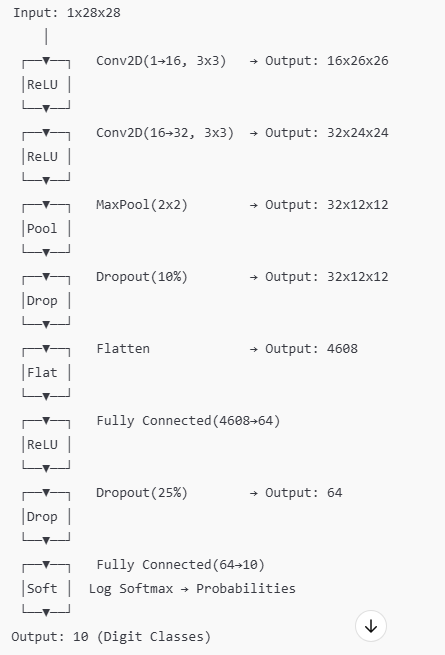

### Define Loss function and Optimizer

In [17]:
torch.manual_seed(0)
model = ConvNet().to(device)
# print(summary((1,28,28), model))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

### Training the model

In [ ]:
num_epochs = 5  # Number of passes through the entire dataset

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Print loss every 100 batches
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
            running_loss = 0.0


f:\CNN\myenv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/5], Step [100/938], Loss: 0.9156
Epoch [1/5], Step [200/938], Loss: 0.2508
Epoch [1/5], Step [300/938], Loss: 0.1836
Epoch [1/5], Step [400/938], Loss: 0.1516
Epoch [1/5], Step [500/938], Loss: 0.1386
Epoch [1/5], Step [600/938], Loss: 0.1268
Epoch [1/5], Step [700/938], Loss: 0.1203
Epoch [1/5], Step [800/938], Loss: 0.1022
Epoch [1/5], Step [900/938], Loss: 0.1115
Epoch [2/5], Step [100/938], Loss: 0.0874
Epoch [2/5], Step [200/938], Loss: 0.0855
Epoch [2/5], Step [300/938], Loss: 0.0818
Epoch [2/5], Step [400/938], Loss: 0.0928
Epoch [2/5], Step [500/938], Loss: 0.0756
Epoch [2/5], Step [600/938], Loss: 0.0684
Epoch [2/5], Step [700/938], Loss: 0.0697
Epoch [2/5], Step [800/938], Loss: 0.0648
Epoch [2/5], Step [900/938], Loss: 0.0619
Epoch [3/5], Step [100/938], Loss: 0.0528
Epoch [3/5], Step [200/938], Loss: 0.0649
Epoch [3/5], Step [300/938], Loss: 0.0588
Epoch [3/5], Step [400/938], Loss: 0.0542
Epoch [3/5], Step [500/938], Loss: 0.0570
Epoch [3/5], Step [600/938], Loss:

### Evaluate the Model

In [ ]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 98.96%


### Plot predicted vs Ground Truth for one example

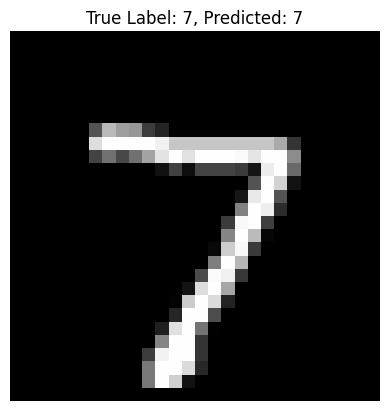

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Select one image from the batch
image = images[0].cpu().numpy().squeeze()  # Convert to NumPy & remove channel dimension
true_label = labels[0].item()

# Get model prediction
model.eval()
with torch.no_grad():
    output = model(images[0].unsqueeze(0))  # Add batch dimension
    _, predicted_label = torch.max(output, 1)
    predicted_label = predicted_label.item()

# Plot the image with labels
plt.imshow(image, cmap='gray')
plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()
